PPT Text Extractor

In [2]:
import gradio as gr
from pptx import Presentation


#Function to Extract Text from PPT
def extract_text_from_ppt(file):
    prs = Presentation(file.name) #load
    text_data = [] #store

    for slide_number, slide in enumerate(prs.slides, start=1):
        slide_text = []
        for shape in slide.shapes:
            if hasattr(shape, "text") and shape.text.strip():
                slide_text.append(shape.text.strip())

        if slide_text:
            text_data.append(f"Slide {slide_number}:\n" + "\n".join(slide_text))

    return "\n\n".join(text_data) if text_data else "No text found in the PPT."

# Create Gradio Interface
iface = gr.Interface(
    fn=extract_text_from_ppt,
    inputs=gr.File(label="Upload PPT File"),
    outputs="text",
    title="PPT Text Extractor",
    description="Upload a .pptx file to extract text from slides."
)
iface.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


PPT Image OCR Extractor

In [ ]:
import os
import pytesseract
from pptx import Presentation
from PIL import Image
import cv2
import numpy as np
import io
import gradio as gr
import re

# Set the Tesseract OCR path
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def preprocess_image(image):
    """Apply noise removal and thresholding to enhance OCR accuracy"""
    open_cv_image = np.array(image.convert("L"))  # Convert to grayscale

    # Apply Gaussian Blur (Reduces noise)
    blurred = cv2.GaussianBlur(open_cv_image, (5, 5), 0)

    # Adaptive Thresholding for better contrast
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Apply Morphological Opening to remove small noise
    kernel = np.ones((2,2), np.uint8)
    clean_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    return Image.fromarray(clean_image)

def clean_text(text):
    """Filter out noisy characters, symbols, and random text"""
    text = text.strip()

    # Remove common OCR artifacts
    text = re.sub(r"[|*_~—@\[\]]+", "", text)  

    # Remove lines with too many symbols (probably noise)
    text = "\n".join(line for line in text.split("\n") if sum(c.isalnum() for c in line) > len(line) * 0.5)

    # Remove excess whitespace
    text = re.sub(r"\s{2,}", " ", text)

    return text if len(text) > 3 else ""  # Ignore extremely short garbage text

def extract_text_from_images(ppt_file):
    """Extracts text from images in PPT slides using OCR"""
    prs = Presentation(ppt_file)
    extracted_text = []

    for slide_number, slide in enumerate(prs.slides, start=1):
        slide_text = f"Slide {slide_number}:\n"

        for shape in slide.shapes:
            if hasattr(shape, "image"):
                image_stream = io.BytesIO(shape.image.blob)
                image = Image.open(image_stream)
                image = preprocess_image(image)  # Apply enhanced image processing

                # Extract text using pytesseract with better settings
                text = pytesseract.image_to_string(image, lang="eng", config="--psm 6 --oem 3")
                text = clean_text(text)  # Clean OCR output
                
                if text:  # Only add meaningful text
                    slide_text += f"\n[Image Text]: {text}\n"

        extracted_text.append(slide_text)

    return "\n".join(extracted_text) if extracted_text else "No readable text found in images."

def gradio_interface(file):
    if file is None:
        return "Please upload a PPT file."
    
    extracted_text = extract_text_from_images(file.name)
    return extracted_text

iface = gr.Interface(
    fn=gradio_interface, 
    inputs=gr.File(label="Upload PowerPoint File (.pptx)"),
    outputs="text",
    title="PPT Image OCR Extractor",
    description="Upload a PowerPoint file to extract text from images using OCR."
)

if __name__ == "__main__":
    iface.launch()


AI Text Summarizer

In [9]:
import gradio as gr
from pptx import Presentation
from transformers import pipeline

# Load the summarization model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Function to extract text from PPT
def extract_text_from_ppt(file):
    prs = Presentation(file.name)  # Load PPT
    text_data = []  # Store extracted text

    for slide_number, slide in enumerate(prs.slides, start=1):
        slide_text = []
        for shape in slide.shapes:
            if hasattr(shape, "text") and shape.text.strip():
                slide_text.append(shape.text.strip())

        if slide_text:
            text_data.append(f"Slide {slide_number}:\n" + "\n".join(slide_text))

    extracted_text = "\n\n".join(text_data) if text_data else "No text found in the PPT."
    return extracted_text

# Function to chunk long text
def chunk_text(text, max_length=1024):
    words = text.split()
    chunks = []
    current_chunk = []

    for word in words:
        current_chunk.append(word)
        if len(" ".join(current_chunk)) > max_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = []

    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

# Function to summarize extracted text
def summarize_ppt(file):
    extracted_text = extract_text_from_ppt(file)  # Extract text
    if extracted_text == "No text found in the PPT.":
        return extracted_text

    chunks = chunk_text(extracted_text)  # Chunk text if needed
    summaries = []

    for chunk in chunks:
        summary = summarizer(chunk, max_length=200, min_length=70, do_sample=False)[0]['summary_text']
        summaries.append(summary)

    return " ".join(summaries)

# Gradio interface
iface = gr.Interface(
    fn=summarize_ppt,
    inputs=gr.File(label="Upload PPT File"),
    outputs=gr.Textbox(label="Summarized Text"),
    title="AI-Powered PPT Summarizer",
    description="Upload a .pptx file, and this tool will extract and summarize its content using AI.",
)

iface.launch()


Device set to use cpu


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


Speech-to-Text Transcription

In [3]:
import speech_recognition as sr
import threading
import tkinter as tk

class SpeechToTextApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Speech-to-Text Transcription")

        self.recognizer = sr.Recognizer()
        self.is_listening = False

        # Create UI elements
        self.start_button = tk.Button(root, text="Start", command=self.start_listening, width=15, height=2)
        self.start_button.pack(pady=10)

        self.stop_button = tk.Button(root, text="Stop", command=self.stop_listening, width=15, height=2, state=tk.DISABLED)
        self.stop_button.pack(pady=10)

        self.text_box = tk.Text(root, height=10, width=50)
        self.text_box.pack(pady=10)

    def update_text_box(self, text):
        """Safely update the text box from a background thread."""
        # Ensure that this update happens in the main thread
        self.text_box.insert(tk.END, text + "\n")
        self.text_box.see(tk.END)  # Auto-scroll to the latest entry

    def listen_and_transcribe(self):
        """Listen and transcribe speech in a background thread."""
        with sr.Microphone() as source:
            self.recognizer.adjust_for_ambient_noise(source, duration=1)
            while self.is_listening:
                try:
                    print("Listening...")
                    audio = self.recognizer.listen(source, timeout=5)
                    text = self.recognizer.recognize_google(audio)
                    print("Transcribed:", text)
                    self.root.after(0, self.update_text_box, text)  # Safe UI update
                except sr.UnknownValueError:
                    self.root.after(0, self.update_text_box, "Could not understand the speech.")
                except sr.RequestError:
                    self.root.after(0, self.update_text_box, "Error: Could not process speech.")
                except sr.WaitTimeoutError:
                    self.root.after(0, self.update_text_box, "Listening timed out. Try speaking again.")
                except Exception as e:
                    # Handle all unexpected errors gracefully
                    self.root.after(0, self.update_text_box, f"Unexpected error: {str(e)}")

    def start_listening(self):
        """Start the listening thread."""
        self.is_listening = True
        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)

        # Create a new thread for listening
        self.listening_thread = threading.Thread(target=self.listen_and_transcribe, daemon=True)
        self.listening_thread.start()

    def stop_listening(self):
        """Safely stop listening and close the app properly."""
        self.is_listening = False
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)
        self.root.after(0, self.update_text_box, "Stopped Listening.")

        # Close the GUI properly
        self.root.quit()  # Stops Tkinter main loop
        self.root.destroy()  # Destroys the GUI window

# Run the Tkinter app
if __name__ == "__main__":
    root = tk.Tk()
    app = SpeechToTextApp(root)
    root.mainloop()


direct summeerise

In [4]:
import gradio as gr
from pptx import Presentation
from transformers import pipeline

# Load the summarization model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Function to extract text from PPT
def extract_text_from_ppt(file):
    prs = Presentation(file.name)  # Load PPT
    text_data = []  # Store extracted text

    for slide_number, slide in enumerate(prs.slides, start=1):
        slide_text = []
        for shape in slide.shapes:
            if hasattr(shape, "text") and shape.text.strip():
                slide_text.append(shape.text.strip())

        if slide_text:
            text_data.append(f"Slide {slide_number}:\n" + "\n".join(slide_text))

    extracted_text = "\n\n".join(text_data) if text_data else "No text found in the PPT."
    return extracted_text

# Function to chunk long text
def chunk_text(text, max_length=1024):
    words = text.split()
    chunks = []
    current_chunk = []

    for word in words:
        current_chunk.append(word)
        if len(" ".join(current_chunk)) > max_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = []

    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

# Function to summarize extracted text
def summarize_ppt(file):
    extracted_text = extract_text_from_ppt(file)  # Extract text
    if extracted_text == "No text found in the PPT.":
        return extracted_text

    chunks = chunk_text(extracted_text)  # Chunk text if needed
    summaries = []

    for chunk in chunks:
        summary = summarizer(chunk, max_length=200, min_length=50, do_sample=False)[0]['summary_text']
        summaries.append(summary)

    return " ".join(summaries)

# Gradio interface
iface = gr.Interface(
    fn=summarize_ppt,
    inputs=gr.File(label="Upload PPT File"),
    outputs=gr.Textbox(label="Summarized Text"),
    title="AI-Powered PPT Summarizer",
    description="Upload a .pptx file, and this tool will extract and summarize its content using AI.",
)

iface.launch()


Device set to use cpu


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
import speech_recognition as sr
import time

def transcribe_and_store(filename="transcriptions.txt"):
    """
    Continuously listens for speech, transcribes it, and appends the text to a file.
    
    Args:
        filename (str): The file where transcribed text will be stored (default: "transcription.txt").
    """
    recognizer = sr.Recognizer()
    
    with sr.Microphone() as source:
        print("Listening...")
        recognizer.adjust_for_ambient_noise(source)  # Reduce background noise

        while True:
            try:
                audio = recognizer.listen(source)  # Capture audio
                
                print("Recognizing...")
                text = recognizer.recognize_google(audio)  # Convert speech to text
                print(f"Transcribed: {text}")

                # Store transcription in a text file
                with open(filename, "a", encoding="utf-8") as file:
                    file.write(text + "\n")

                print(f"Saved to {filename}")

            except sr.UnknownValueError:
                print("Could not understand the audio.")
            except sr.RequestError as e:
                print(f"Speech Recognition request failed: {e}")
            except KeyboardInterrupt:
                print("\nStopped listening. Transcription saved.")
                break

if __name__ == "__main__":
    transcribe_and_store()


In [ ]:
import speech_recognition as sr
import time

def transcribe_and_store(filename="transcriptions.txt"):
    """
    Continuously listens for speech, transcribes it, and appends the text to a file.
    
    Args:
        filename (str): The file where transcribed text will be stored (default: "transcription.txt").
    """
    recognizer = sr.Recognizer()
    
    with sr.Microphone() as source:
        print("Listening... (Press Ctrl+C to stop)")
        recognizer.adjust_for_ambient_noise(source)  # Reduce background noise

        while True:
            try:
                audio = recognizer.listen(source)  # Capture audio
                
                print("Recognizing...")
                text = recognizer.recognize_google(audio)  # Convert speech to text
                print(f"Transcribed: {text}")

                # Store transcription in a text file
                with open(filename, "a", encoding="utf-8") as file:
                    file.write(text + "\n")

                print(f"Saved to {filename}")

            except sr.UnknownValueError:
                print("Could not understand the audio.")
            except sr.RequestError as e:
                print(f"Speech Recognition request failed: {e}")
            except KeyboardInterrupt:
                print("\nStopped listening. Transcription saved.")
                break

if __name__ == "__main__":
    transcribe_and_store()


In [ ]:
import speech_recognition as sr
import os
import subprocess
import tempfile
import re
from translate import Translator
import langdetect

def translate_hinglish(text, to_lang="en"):
    """Translates text, handling Hinglish words by word."""
    translator = Translator(to_lang=to_lang)
    words = text.split()
    translated_words = []
    for word in words:
        try:
            lang = langdetect.detect(word)
            if lang == "en" or lang == "hi":
                translated_words.append(translator.translate(word))
            else:
                translated_words.append(word) # Keep Hinglish as is.
        except langdetect.LangDetectException:
            translated_words.append(word) # Keep unknown words as is.
    return " ".join(translated_words)

def transcribe_and_translate_audio(audio_file_path, output_file_path="transcription.txt"):
    """Transcribes audio, translates (handling Hinglish), and segregates words."""

    recognizer = sr.Recognizer()
    try:
        _, file_extension = os.path.splitext(audio_file_path)
        file_extension = file_extension.lower()

        if file_extension not in [".wav", ".aiff", ".aiff-c", ".flac"]:
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=True) as temp_wav:
                try:
                    subprocess.run(
                        ["ffmpeg", "-i", audio_file_path, temp_wav.name],
                        check=True,
                        capture_output=True,
                        text=True,
                    )
                    audio_file_path = temp_wav.name
                except subprocess.CalledProcessError as e:
                    print(f"Error during audio conversion: {e.stderr}")
                    return

        with sr.AudioFile(audio_file_path) as source:
            audio_data = recognizer.record(source)

        try:
            transcription = recognizer.recognize_google(audio_data, language="en-IN,hi-IN")
        except sr.UnknownValueError:
            transcription = "Could not understand audio"
        except sr.RequestError as e:
            transcription = f"Could not request results from Google Speech Recognition service; {e}"

        if transcription == "Could not understand audio" or "Could not request results from Google Speech Recognition service" in transcription:
            with open(output_file_path, "w", encoding="utf-8") as file:
                file.write(transcription)
            return

        words = transcription.split()
        language_words = {"en": [], "hi": [], "hinglish": [], "unknown": []}

        for word in words:
            word = word.lower()
            try:
                if re.search(r'[a-zA-Z][\u0900-\u097F]', word) or re.search(r'[\u0900-\u097F][a-zA-Z]', word) or re.search(r'[a-zA-Z]+\d+[a-zA-Z]*', word):
                    language_words["hinglish"].append(word)
                elif re.search(r'[\u0900-\u097F]+', word):
                    language_words["hi"].append(word)
                elif re.search(r'[a-zA-Z]+', word):
                    language_words["en"].append(word)
                else:
                    language_words["unknown"].append(word)
            except Exception as e:
                language_words["unknown"].append(word)

        try:
            translated_text = translate_hinglish(transcription)
        except Exception as translation_error:
            translated_text = f"Translation failed: {translation_error}"

        with open(output_file_path, "w", encoding="utf-8") as file:
            file.write("Raw Transcription:\n" + transcription + "\n\n")
            file.write("Translated Transcription(English):\n" + translated_text + "\n\n")
            file.write("English: " + " ".join(language_words["en"]) + "\n")
            file.write("Hindi: " + " ".join(language_words["hi"]) + "\n")
            file.write("Hinglish: " + " ".join(language_words["hinglish"]) + "\n")
            file.write("Unknown: " + " ".join(language_words["unknown"]))

        print(f"Transcription, translation, and language segregation saved to {output_file_path}")

    except FileNotFoundError:
        print(f"Error: Audio file not found at {audio_file_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage:
audio_file = "phase 1 ppt.wav"
if os.path.exists(audio_file):
    transcribe_and_translate_audio(audio_file)
else:
    print(f"Audio file '{audio_file}' does not exist.")

In [ ]:
import os
from pptx import Presentation
from translate import Translator
import langdetect

def translate_hinglish(text, to_lang="en"):
    """Translates text, handling Hinglish words by word."""
    translator = Translator(to_lang=to_lang)
    words = text.split()
    translated_words = []
    for word in words:
        try:
            lang = langdetect.detect(word)
            if lang == "en" or lang == "hi":
                translated_words.append(translator.translate(word))
            else:
                translated_words.append(word)  # Keep Hinglish as is.
        except langdetect.LangDetectException:
            translated_words.append(word)  # Keep unknown words as is.
    return " ".join(translated_words)

def extract_text_from_ppt(ppt_file_path, output_file_path="extracted_text.txt"):
    """Extracts text from PPT slides, translates (handling Hinglish), and saves to a file."""

    try:
        # Check if the PPT file exists
        if not os.path.exists(ppt_file_path):
            print(f"Error: PPT file not found at {ppt_file_path}")
            return
        
        # Load the presentation
        presentation = Presentation(ppt_file_path)
        ppt_text = []

        # Extract text from each slide
        for slide in presentation.slides:
            slide_text = []
            for shape in slide.shapes:
                if hasattr(shape, "text"):
                    slide_text.append(shape.text.strip())
            ppt_text.append(" ".join(slide_text))

        # Combine all slide text
        combined_text = "\n\n".join(ppt_text)

        # Translate the extracted text, if needed
        try:
            translated_text = translate_hinglish(combined_text)
        except Exception as translation_error:
            translated_text = f"Translation failed: {translation_error}"

        # Save the extracted and translated text to a file
        with open(output_file_path, "w", encoding="utf-8") as file:
            file.write("Extracted Text from PPT:\n" + combined_text + "\n\n")
            file.write("Translated Text (English):\n" + translated_text)

        print(f"Extracted text and translation saved to {output_file_path}")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage:
ppt_file = "phase 1 ppt.pptx"
if os.path.exists(ppt_file):
    extract_text_from_ppt(ppt_file)
else:
    print(f"PPT file '{ppt_file}' does not exist.")


In [ ]:
import nltk

# Download the required NLTK resources
nltk.download('averaged_perceptron_tagger')


FEEDBACK:
Fair attempt. You covered some key topics, but quite a few were missed.
You missed 2 important keyword(s) from the presentation.
Missed keywords: analysis, speech
You included 2 extra keyword(s) that were not part of the presentation.
Extra keywords: student, system

 Keywords from PPT: 7
Keywords from Transcription: 7

Keywords from PPT:
ai, analysis, feedback, presentation, slide, speech, text

Keywords from Transcription:
ai, feedback, presentation, slide, student, system, text

✅ Matching Keywords (5):
ai, feedback, presentation, slide, text
❌ Missing from Speech (2):
analysis, speech
⚠️ Extra in Speech (2):
student, system

 Accuracy of Coverage: 71.43%


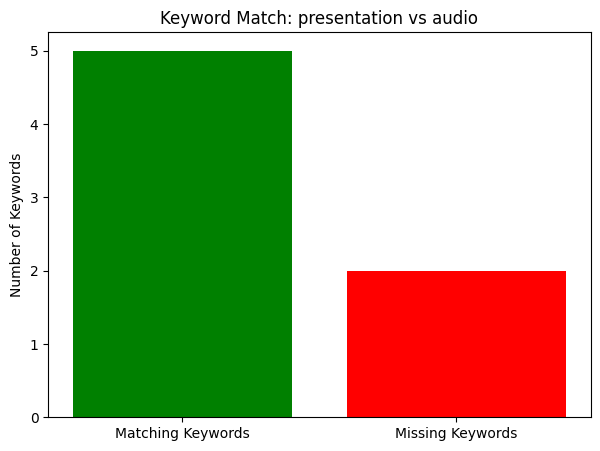

In [5]:
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
import textwrap  # Importing textwrap module

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')  # Download POS Tagger

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def load_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read().lower()

def extract_keywords(text, max_keywords=None):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    # Remove stop words and non-alphanumeric words
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    
    # Lemmatize each word to its base form
    lemmatized_keywords = [lemmatizer.lemmatize(word) for word in keywords]

    # Count word frequency
    keyword_counts = Counter(lemmatized_keywords)
    
    # Sort keywords by frequency and limit them to max_keywords if specified
    sorted_keywords = [keyword for keyword, _ in keyword_counts.most_common(max_keywords)]
    
    return set(sorted_keywords)

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())  # Add the synonym to the set
    return synonyms

def compare_keywords(keywords1, keywords2):
    matches = set()
    only_in_1 = set(keywords1)
    only_in_2 = set(keywords2)
    
    # Find exact matches first
    for word1 in keywords1:
        if word1 in keywords2:
            matches.add(word1)
    
    # Match words semantically using synonyms
    for word1 in keywords1:
        for word2 in keywords2:
            if word1 != word2 and (word2 in get_synonyms(word1)):
                matches.add(word1)

    # Remove matched words from both sets
    only_in_1 -= matches
    only_in_2 -= matches
    
    accuracy = (len(matches) / len(keywords1)) * 100 if keywords1 else 0
    return matches, only_in_1, only_in_2, accuracy

def plot_graph(match_count, mismatch_count):
    labels = ['Matching Keywords', 'Missing Keywords']
    values = [match_count, mismatch_count]
    colors = ['green', 'red']
    
    plt.figure(figsize=(7,5))
    plt.bar(labels, values, color=colors)
    plt.title("Keyword Match: presentation vs audio")
    plt.ylabel("Number of Keywords")
    plt.show()

def generate_feedback(matches, missing_in_speech, extra_in_speech, accuracy):
    feedback = []

    # Feedback on accuracy
    if accuracy >= 90:
        feedback.append("Excellent! Your speech closely matched the presentation content.")
    elif accuracy >= 75:
        feedback.append("Good job! Most of the key points from the presentation were covered.")
    elif accuracy >= 50:
        feedback.append("Fair attempt. You covered some key topics, but quite a few were missed.")
    else:
        feedback.append("Needs Improvement. A large portion of the presentation content was not covered in the speech.")

    # Feedback on missing keywords
    if missing_in_speech:
        feedback.append(f"You missed {len(missing_in_speech)} important keyword(s) from the presentation.")
        few_missed = list(sorted(missing_in_speech))[:10]
        feedback.append("Missed keywords: " + ", ".join(few_missed) + ("..." if len(missing_in_speech) > 10 else ""))

    # Feedback on extra/unrelated keywords
    if extra_in_speech:
        feedback.append(f"You included {len(extra_in_speech)} extra keyword(s) that were not part of the presentation.")
        few_extra = list(sorted(extra_in_speech))[:10]
        feedback.append("Extra keywords: " + ", ".join(few_extra) + ("..." if len(extra_in_speech) > 10 else ""))

    # Print feedback
    print("\nFEEDBACK:")
    for line in feedback:
        print(line)

# Load text files
ppt_text = load_file("extracted_text.txt")
speech_text = load_file("transcription.txt")
max_keywords = 7

# Extract keywords
ppt_keywords = extract_keywords(ppt_text, max_keywords=max_keywords)
speech_keywords = extract_keywords(speech_text, max_keywords=max_keywords)

# Compare the keywords
matches, missing_in_speech, extra_in_speech, accuracy = compare_keywords(ppt_keywords, speech_keywords)

# Show feedback after comparison
generate_feedback(matches, missing_in_speech, extra_in_speech, accuracy)

# Output results with textwrap for better formatting
print("\n Keywords from PPT:", len(ppt_keywords))
print("Keywords from Transcription:", len(speech_keywords))

# Wrap the keywords and print them
print("\nKeywords from PPT:")
print("\n".join(textwrap.wrap(", ".join(sorted(ppt_keywords)), width=80)))

print("\nKeywords from Transcription:")
print("\n".join(textwrap.wrap(", ".join(sorted(speech_keywords)), width=80)))

print(f"\n✅ Matching Keywords ({len(matches)}):")
print("\n".join(textwrap.wrap(", ".join(sorted(matches)), width=80)))

print(f"❌ Missing from Speech ({len(missing_in_speech)}):")
print("\n".join(textwrap.wrap(", ".join(sorted(missing_in_speech)), width=80)))

print(f"⚠️ Extra in Speech ({len(extra_in_speech)}):")
print("\n".join(textwrap.wrap(", ".join(sorted(extra_in_speech)), width=80)))

print(f"\n Accuracy of Coverage: {accuracy:.2f}%")

# Show graph
plot_graph(len(matches), len(missing_in_speech))


C:\Users\PRADIPTI CHAKRABORTY\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package punkt to C:\Users\PRADIPTI
[nltk_data]     CHAKRABORTY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\PRADIPTI
[nltk_data]     CHAKRABORTY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\PRADIPTI
[nltk_data]     CHAKRABORTY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\PRADIPTI
[nltk_data]     CHAKRABORTY\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



✅ Total PPT Keywords: 250
✅ Matched Keywords: 133
❌ Missed from PPT: 117
🗣️ Extra from Speech: 88
📈 Accuracy: 53.20%


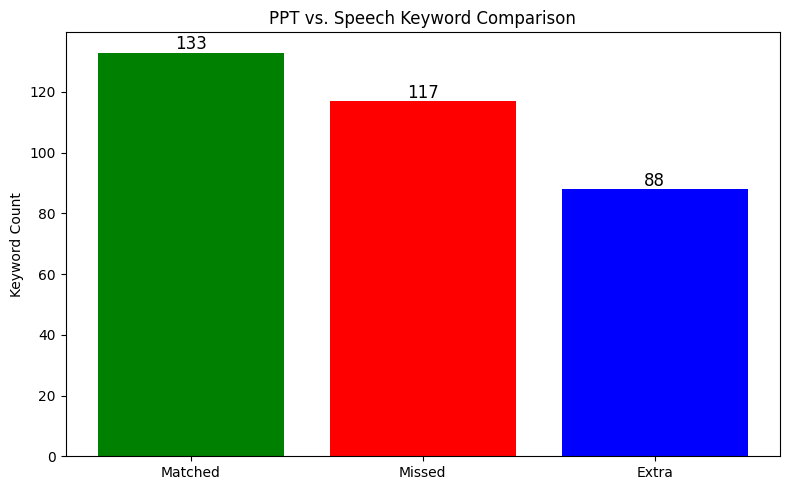

In [19]:
import os
import nltk
import string
from pptx import Presentation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# ✅ Step 1: Extract full text from PowerPoint
def extract_text_from_ppt(ppt_path):
    prs = Presentation(ppt_path)
    text = ""
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text += shape.text + " "
            if hasattr(shape, "table"):
                for row in shape.table.rows:
                    for cell in row.cells:
                        text += cell.text + " "
    return text.strip()

# ✅ Step 2: Preprocess text into keywords (clean, lemmatize, stem)
def preprocess_text(text):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text.lower())
    keywords = []
    for word in words:
        if word not in stop_words and word not in string.punctuation and word.isalnum():
            lemma = lemmatizer.lemmatize(word)
            stem = stemmer.stem(lemma)
            keywords.append(stem)
    return set(keywords)

# ✅ Step 3: Fuzzy match keywords with score ≥ 75
def fuzzy_match(ppt_keywords, speech_keywords, threshold=75):
    matched = set()
    missed = set(ppt_keywords)
    extra = set(speech_keywords)

    for ppt_word in ppt_keywords:
        for speech_word in speech_keywords:
            score = fuzz.ratio(ppt_word, speech_word)
            if score >= threshold:
                matched.add(ppt_word)
                missed.discard(ppt_word)
                extra.discard(speech_word)
                break

    return matched, missed, extra

# ✅ Step 4: Accuracy calculation
def calculate_accuracy(matched, total_keywords):
    if len(total_keywords) == 0:
        return 0
    return (len(matched) / len(total_keywords)) * 100

# ✅ Step 5: Plot result
def plot_results(matched, missed, extra):
    categories = ['Matched', 'Missed', 'Extra']
    values = [len(matched), len(missed), len(extra)]

    colors = ['green', 'red', 'blue']
    plt.figure(figsize=(8, 5))
    bars = plt.bar(categories, values, color=colors)
    plt.title("PPT vs. Speech Keyword Comparison")
    plt.ylabel("Keyword Count")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

# ✅ Step 6: Full run function
def run_keyword_match(ppt_path, speech_path):
    if not os.path.exists(ppt_path) or not os.path.exists(speech_path):
        print("❌ PPT or transcription file not found.")
        return

    ppt_text = extract_text_from_ppt(ppt_path)
    with open(speech_path, "r", encoding="utf-8") as f:
        speech_text = f.read()

    ppt_keywords = preprocess_text(ppt_text)
    speech_keywords = preprocess_text(speech_text)

    matched, missed, extra = fuzzy_match(ppt_keywords, speech_keywords)

    accuracy = calculate_accuracy(matched, ppt_keywords)
    print(f"\n✅ Total PPT Keywords: {len(ppt_keywords)}")
    print(f"✅ Matched Keywords: {len(matched)}")
    print(f"❌ Missed from PPT: {len(missed)}")
    print(f"🗣️ Extra from Speech: {len(extra)}")
    print(f"📈 Accuracy: {accuracy:.2f}%")

    plot_results(matched, missed, extra)

# 📁 File paths
ppt_file = "phase 1 ppt.pptx"
speech_file = "transcription.txt"

run_keyword_match(ppt_file, speech_file)


In [7]:
!pip install python-pptx ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py widgetsnbextension
!jupyter nbextension enable widgetsnbextension --user


Defaulting to user installation because normal site-packages is not writeable


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--p

In [ ]:
# 📦 Required Libraries
import os
from pptx import Presentation
from IPython.display import display, HTML
import ipywidgets as widgets

# 📁 UI Elements
upload_widget = widgets.FileUpload(
    accept='.pptx',
    multiple=False,
    description='Upload PPT'
)

analyze_button = widgets.Button(
    description="Analyze PPT",
    button_style='success'
)

output = widgets.Output()

# 💻 Display Widgets
display(HTML("<h3>Step 1: Upload your PowerPoint (.pptx) file</h3>"))
display(upload_widget)
display(HTML("<h3>Step 2: Click the button to analyze</h3>"))
display(analyze_button)
display(output)

# 🧠 PPT Analysis Function
def analyze_ppt(filepath):
    prs = Presentation(filepath)
    num_slides = len(prs.slides)
    total_words = 0
    slides_with_images = 0
    slides_with_titles = 0

    for slide in prs.slides:
        slide_text = ""
        has_image = False
        has_title = False

        for shape in slide.shapes:
            if shape.has_text_frame:
                slide_text += shape.text + " "
                if shape.text_frame.text.strip().lower() not in ['', 'heading']:
                    has_title = True
            if shape.shape_type == 13:  # Picture
                has_image = True

        word_count = len(slide_text.split())
        total_words += word_count

        if has_image:
            slides_with_images += 1
        if has_title:
            slides_with_titles += 1

    avg_words_per_slide = total_words / num_slides if num_slides else 0

    feedback = []
    score = 0

    # 📌 Criteria 1: Number of Slides (2 pts)
    if 5 <= num_slides <= 15:
        score += 2
        feedback.append("✅ Good number of slides.")
    elif num_slides < 5:
        score += 1
        feedback.append("⚠️ Too few slides.")
    else:
        score += 1
        feedback.append("⚠️ Too many slides; consider trimming.")

    # 📌 Criteria 2: Wordiness (2 pts)
    if avg_words_per_slide <= 40:
        score += 2
        feedback.append("✅ Slides are concise and to the point.")
    elif avg_words_per_slide <= 60:
        score += 1
        feedback.append("⚠️ Slightly text-heavy. Could be more visual.")
    else:
        feedback.append("⚠️ Too much text per slide. Try summarizing.")

    # 📌 Criteria 3: Use of images (2 pts)
    image_ratio = slides_with_images / num_slides if num_slides else 0
    if image_ratio >= 0.5:
        score += 2
        feedback.append("✅ Good use of visuals.")
    elif image_ratio >= 0.3:
        score += 1
        feedback.append("⚠️ Add a few more images for better engagement.")
    else:
        feedback.append("⚠️ Slides are lacking visuals. Use more images.")

    # 📌 Criteria 4: Titles (2 pts)
    title_ratio = slides_with_titles / num_slides if num_slides else 0
    if title_ratio >= 0.8:
        score += 2
        feedback.append("✅ Most slides have clear titles.")
    elif title_ratio >= 0.5:
        score += 1
        feedback.append("⚠️ Some slides lack clear titles.")
    else:
        feedback.append("⚠️ Most slides don’t have titles. Add them for clarity.")

    # 📌 Criteria 5: Slide pacing (2 pts)
    if 7 <= num_slides <= 12:
        score += 2
        feedback.append("✅ Excellent slide pacing.")
    elif 5 <= num_slides < 7 or 12 < num_slides <= 15:
        score += 1
        feedback.append("⚠️ Slight pacing issues, review slide distribution.")
    else:
        feedback.append("⚠️ Consider restructuring for better flow.")

    final_rating = f"{score}/10"
    return final_rating, feedback

# 🚀 Button Handler
def on_analyze_clicked(b):
    output.clear_output()
    if not upload_widget.value:
        with output:
            print("❌ No file uploaded yet.")
        return

    # ✅ Extract file from upload (modern ipywidgets)
    upload_data = upload_widget.value[0]
    content = upload_data['content']
    filename = upload_data['name']

    # 📁 Save uploaded file
    os.makedirs('uploaded', exist_ok=True)
    filepath = os.path.join('uploaded', filename)
    with open(filepath, 'wb') as f:
        f.write(content)

    # 🔍 Analyze PPT
    rating, feedback = analyze_ppt(filepath)

    # 🖨️ Show result
    with output:
        print(f"\n📊 Final Rating: {rating}")
        print("\n📝 Feedback:")
        for comment in feedback:
            print(" -", comment)

# 🔗 Connect Button
analyze_button.on_click(on_analyze_clicked)


FileUpload(value=(), accept='.pptx', description='Upload PPT')

Button(button_style='success', description='Analyze PPT', style=ButtonStyle())

Output()

In [11]:
from pptx import Presentation
import yake
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import numpy as np
import random

# Load models
question_generator = pipeline("text2text-generation", model="valhalla/t5-small-qg-hl")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def extract_slide_texts(ppt_file):
    """Extract text from each slide in the PowerPoint file."""
    prs = Presentation(ppt_file)
    slide_texts = []
    for slide in prs.slides:
        text = ""
        for shape in slide.shapes:
            if shape.has_text_frame:
                for paragraph in shape.text_frame.paragraphs:
                    for run in paragraph.runs:
                        text += run.text + " "
        slide_texts.append(text.strip())
    return slide_texts

def extract_key_phrases(text, count=3):
    """Extract key phrases from text using YAKE."""
    kw_extractor = yake.KeywordExtractor(top=count, n=3)
    keywords = kw_extractor.extract_keywords(text)
    return [kw[0] for kw in keywords]

def generate_question(context, answer):
    """Generate a question based on context with highlighted answer."""
    highlighted_context = context.replace(answer, f"<hl>{answer}<hl>")
    input_text = f"generate question: {highlighted_context}"
    try:
        result = question_generator(input_text)
        question = result[0]['generated_text'].strip()
        if not question:
            return "What is the main idea of this slide?"
        return question
    except Exception as e:
        print(f"Error generating question: {e}")
        return "What is the main idea of this slide?"

def compute_similarity(user_answer, expected_answer):
    """Compute cosine similarity between user and expected answers."""
    user_emb = embedding_model.encode(user_answer)
    expected_emb = embedding_model.encode(expected_answer)
    similarity = util.cos_sim(user_emb, expected_emb).item()
    return similarity

def conduct_qa_session(slide_texts):
    """Conduct the Q&A session with randomly selected slides."""
    # Identify slides with at least 10 words
    sufficient_slides = [i for i, text in enumerate(slide_texts) if len(text.split()) >= 10]
    
    if not sufficient_slides:
        print("No slides with sufficient content found.")
        return [], [], [], [], []
    
    # Randomly select up to 5 slides
    if len(sufficient_slides) > 5:
        selected_indices = random.sample(sufficient_slides, 5)
    else:
        selected_indices = sufficient_slides
    
    num_questions = len(selected_indices)
    print(f"\nYou will be asked {num_questions} questions from random slides.")
    print("Please provide answers to the best of your knowledge.")
    print("If you skip a question, it will be considered incorrect.\n")
    
    questions = []
    expected_answers = []
    slide_numbers = []
    asked_questions = set()

    for idx in selected_indices:
        text = slide_texts[idx]
        key_phrases = extract_key_phrases(text)
        if not key_phrases:
            key_phrase = random.choice(text.split())
        else:
            key_phrase = random.choice(key_phrases)
        
        question = generate_question(text, key_phrase)
        attempt = 0
        max_attempts = 3
        while (question in asked_questions and attempt < max_attempts and key_phrases):
            key_phrase = random.choice(key_phrases)
            question = generate_question(text, key_phrase)
            attempt += 1
        
        if question not in asked_questions:
            questions.append(question)
            expected_answers.append(key_phrase)
            slide_numbers.append(idx + 1)
            asked_questions.add(question)

    user_answers = []
    similarities = []

    for i, question in enumerate(questions):
        print(f"\n🔹 Question {i + 1} (from Slide {slide_numbers[i]}): {question}")
        answer = input("🧠 Your answer: ").strip()
        user_answers.append(answer)
        if answer:
            similarity = compute_similarity(answer, expected_answers[i])
        else:
            similarity = 0.0  # Skipped questions scored as 0
        similarities.append(similarity)

        print(f"📌 You answered: {answer}")
        print(f"✅ Key concept we expected: {expected_answers[i]}")
        print(f"🔗 Similarity Score: {similarity:.2f}")

    return questions, user_answers, similarities, expected_answers, slide_numbers

def generate_feedback(similarities, expected_answers, slide_numbers):
    """Generate feedback with a score out of 10."""
    if not similarities:
        return "No feedback available."

    avg_similarity = np.mean(similarities)
    score = avg_similarity * 10

    struggled_topics = [
        (expected_answers[i], slide_numbers[i])
        for i, sim in enumerate(similarities) if sim < 0.6
    ]
    strong_topics = [
        expected_answers[i]
        for i, sim in enumerate(similarities) if sim > 0.8
    ]

    feedback = "### Your Performance\n"
    feedback += f"- **Your Score**: {score:.1f} out of 10\n\n"

    if struggled_topics:
        feedback += "### Areas to Improve\n"
        for topic, slide in struggled_topics:
            feedback += f"- **{topic}** (Slide {slide}) – Response lacked accuracy.\n"
        feedback += "\n📝 **Tip**: Revisit these slides to strengthen your understanding.\n\n"

    if strong_topics:
        feedback += "### Strengths\n"
        for topic in strong_topics:
            feedback += f"- **{topic}** – Well explained!\n"
        feedback += "\n"

    if score >= 8:
        overall_rating = "Excellent"
        encouragement = "Great job! You have a strong grasp of the material."
    elif score >= 6:
        overall_rating = "Good"
        encouragement = "Nice effort! A bit more focus can boost your score."
    elif score >= 4:
        overall_rating = "Fair"
        encouragement = "You’re on the right track. Review the slides for better results."
    else:
        overall_rating = "Needs Improvement"
        encouragement = "Keep practicing! Focus on key concepts in the slides."

    feedback += f"\n**🏆 Overall Rating**: {overall_rating}\n"
    feedback += f"{encouragement}\n"

    return feedback

def main(ppt_file):
    """Main function to run the Q&A session."""
    print("📂 Loading presentation and extracting text...")
    slide_texts = extract_slide_texts(ppt_file)
    
    if not slide_texts:
        print("❌ No content found in slides.")
        return
    
    print(f"✅ Extracted {len(slide_texts)} slides.\n")
    
    questions, user_answers, similarities, expected_answers, slide_numbers = conduct_qa_session(slide_texts)
    if not questions:
        print("No questions generated. Please check the presentation content.")
    else:
        feedback = generate_feedback(similarities, expected_answers, slide_numbers)
        print("\n📊 ## Feedback Report")
        print(feedback)

if __name__ == "__main__":
    ppt_file = "phase 1 ppt.pptx"  # Replace with your PPT file path
    main(ppt_file)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu


📂 Loading presentation and extracting text...
✅ Extracted 12 slides.


You will be asked 5 questions from random slides.
Please provide answers to the best of your knowledge.
If you skip a question, it will be considered incorrect.


🔹 Question 1 (from Slide 8): What is OCR used for images?
📌 You answered: 
✅ Key concept we expected: Tesseract OCR
🔗 Similarity Score: 0.00

🔹 Question 2 (from Slide 6): What is the Flowchart?
📌 You answered: 
✅ Key concept we expected: User Uploads PPT
🔗 Similarity Score: 0.00

🔹 Question 3 (from Slide 3): What is essential for academic success?
📌 You answered: 
✅ Key concept we expected: Introduction Effective communication
🔗 Similarity Score: 0.00

🔹 Question 4 (from Slide 2): What is OCR?
📌 You answered: 
✅ Key concept we expected: Problem Statement Methodology
🔗 Similarity Score: 0.00

🔹 Question 5 (from Slide 9): What is the advantage of the AI?
📌 You answered: 
✅ Key concept we expected: easier content evaluation
🔗 Similarity Score: 0.00

📊 ## Feed

In [2]:
from pptx import Presentation
import yake
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import numpy as np
import random

# Load models
question_generator = pipeline("text2text-generation", model="valhalla/t5-small-qg-hl")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')


def extract_slide_texts(ppt_file):
    """Extract non-empty text from slides."""
    prs = Presentation(ppt_file)
    slide_texts = []
    for slide in prs.slides:
        text = " ".join(
            run.text for shape in slide.shapes if shape.has_text_frame
            for paragraph in shape.text_frame.paragraphs
            for run in paragraph.runs
        ).strip()
        if len(text.split()) >= 5:  # Filter out title-only or empty slides
            slide_texts.append(text)
    return slide_texts


def extract_key_phrases(text, count=5):
    """Extract more meaningful key phrases using YAKE."""
    kw_extractor = yake.KeywordExtractor(top=count, n=3)
    keywords = kw_extractor.extract_keywords(text)
    return [kw[0] for kw in keywords if len(kw[0].split()) >= 2 and len(kw[0]) > 10]


def generate_question(context, answer):
    """Generate a question based on context and answer."""
    if answer not in context:
        context += f" {answer}"
    highlighted_context = context.replace(answer, f"<hl>{answer}<hl>")
    input_text = f"generate question: {highlighted_context}"
    try:
        result = question_generator(input_text)
        question = result[0]['generated_text'].strip()
        return question if question else f"What is the main idea related to: {answer}?"
    except Exception as e:
        print(f"Error generating question: {e}")
        return f"What is the main idea related to: {answer}?"


def compute_similarity(user_answer, expected_answer):
    """Compute similarity score between user and expected answers."""
    if not user_answer:
        return 0.0

    if expected_answer.lower() in user_answer.lower():
        return 1.0

    user_key_phrases = extract_key_phrases(user_answer, count=3)
    if not user_key_phrases:
        return util.cos_sim(embedding_model.encode(user_answer), embedding_model.encode(expected_answer)).item()

    similarities = [
        util.cos_sim(embedding_model.encode(phrase), embedding_model.encode(expected_answer)).item()
        for phrase in user_key_phrases
    ]
    return max(similarities)


def conduct_qa_session(slide_texts):
    """Conduct Q&A session from randomly selected slides."""
    sufficient_slides = [i for i, text in enumerate(slide_texts)]
    if not sufficient_slides:
        print("No valid slides found.")
        return [], [], [], [], []

    selected_indices = random.sample(sufficient_slides, min(5, len(sufficient_slides)))

    print(f"\nYou will be asked {len(selected_indices)} questions from random slides.")
    print("Please provide answers to the best of your knowledge.")
    print("If you skip a question, it will be considered incorrect.\n")

    questions, expected_answers, slide_numbers, user_answers, similarities = [], [], [], [], []
    asked_questions = set()

    for idx in selected_indices:
        text = slide_texts[idx]
        key_phrases = extract_key_phrases(text)
        key_phrase = random.choice(key_phrases) if key_phrases else random.choice(text.split())

        question = generate_question(text, key_phrase)
        attempt = 0
        while question in asked_questions and attempt < 3 and key_phrases:
            key_phrase = random.choice(key_phrases)
            question = generate_question(text, key_phrase)
            attempt += 1

        if question not in asked_questions:
            questions.append(question)
            expected_answers.append(key_phrase)
            slide_numbers.append(idx + 1)
            asked_questions.add(question)

    for i, question in enumerate(questions):
        print(f"\n🔹 Question {i + 1} (from Slide {slide_numbers[i]}): {question}")
        answer = input("🧠 Your answer: ").strip()
        user_answers.append(answer)
        similarity = compute_similarity(answer, expected_answers[i])
        similarities.append(similarity)

        print(f"📌 You answered: {answer}")
        print(f"✅ Key concept we expected: {expected_answers[i]}")
        print(f"🔗 Similarity Score: {similarity:.2f}")

    return questions, user_answers, similarities, expected_answers, slide_numbers


def generate_feedback(similarities, expected_answers, slide_numbers):
    """Generate detailed feedback based on user performance."""
    if not similarities:
        return "No feedback available."

    avg_similarity = np.mean(similarities)
    score = avg_similarity * 10

    struggled_topics = [
        (expected_answers[i], slide_numbers[i])
        for i, sim in enumerate(similarities) if sim < 0.6
    ]
    strong_topics = [
        expected_answers[i]
        for i, sim in enumerate(similarities) if sim > 0.8
    ]

    feedback = "### Your Performance\n"
    feedback += f"- **Your Score**: {score:.1f} out of 10\n\n"

    if struggled_topics:
        feedback += "### Areas to Improve\n"
        for topic, slide in struggled_topics:
            feedback += f"- **{topic}** (Slide {slide}) – Response lacked accuracy.\n"
        feedback += "\n📝 **Tip**: Revisit these slides to strengthen your understanding.\n\n"

    if strong_topics:
        feedback += "### Strengths\n"
        for topic in strong_topics:
            feedback += f"- **{topic}** – Well explained!\n"
        feedback += "\n"

    if score >= 8:
        overall_rating = "Excellent"
        encouragement = "Great job! You have a strong grasp of the material."
    elif score >= 6:
        overall_rating = "Good"
        encouragement = "Nice effort! A bit more focus can boost your score."
    elif score >= 4:
        overall_rating = "Fair"
        encouragement = "You’re on the right track. Review the slides for better results."
    else:
        overall_rating = "Needs Improvement"
        encouragement = "Keep practicing! Focus on key concepts in the slides."

    feedback += f"\n**🏆 Overall Rating**: {overall_rating}\n"
    feedback += f"{encouragement}\n"

    return feedback


def main(ppt_file):
    """Main runner function."""
    print("📂 Loading presentation and extracting text...")
    slide_texts = extract_slide_texts(ppt_file)

    print(f"✅ Extracted {len(slide_texts)} slides with content.\n")
    for i, text in enumerate(slide_texts):
        print(f"📄 Slide {i+1} preview: {text[:80]}... ({len(text.split())} words)")

    questions, user_answers, similarities, expected_answers, slide_numbers = conduct_qa_session(slide_texts)
    if not questions:
        print("No questions generated. Please check the presentation content.")
    else:
        feedback = generate_feedback(similarities, expected_answers, slide_numbers)
        print("\n📊 ## Feedback Report")
        print(feedback)


if __name__ == "__main__":
    ppt_file = "phase 2 ppt.pptx"  # Replace with your PowerPoint file
    main(ppt_file)


Device set to use cpu


📂 Loading presentation and extracting text...
✅ Extracted 9 slides with content.

📄 Slide 1 preview: Slide Insight: AI-Based Presentation Evaluation and Guidance PRESENTED BY~  PRAD... (26 words)
📄 Slide 2 preview: Introduction Need for AI Solution Problem Statement Methodology P PT summarizati... (18 words)
📄 Slide 3 preview: Introduction Effective communication is essential for academic success, especial... (52 words)
📄 Slide 4 preview: Need for AI Solution Students struggle with  weak arguments, missing key points,... (41 words)
📄 Slide 5 preview: Problem Statement Content Issues:  Disorganized slides, missing key points, weak... (45 words)
📄 Slide 6 preview: Flowchart User Uploads ppt Extracting Text & Images AI Understands Content Slide... (35 words)
📄 Slide 7 preview: Text Processing OCR Model . PPT Text Extraction NLP for Summarization  2. Speech... (43 words)
📄 Slide 8 preview: Future Work to be Done   Completed Work So Far: PPT Summarization Audio Transcri... (49 words)
📄 Slid